<a href="https://colab.research.google.com/github/DianaKahar/Data_management3/blob/main/P137263_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**STQD6324 DATA MANAGEMENT**

**INTRODUCTION**

In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1e6f417a89e9ef8dc0ef2985a0c2148f2aebec9b6d0969af2c224d74fe678c57
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
import pandas as pd
from sklearn.datasets import load_iris
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
import numpy as np

In [4]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target

In [5]:
iris_df.to_csv('iris.csv', index=False)

In [6]:
spark = SparkSession.builder.appName("IrisClassification").getOrCreate()

In [7]:
data = spark.read.csv('iris.csv', header=True, inferSchema=True)
data.show()

+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|    0|
|              4.9|             3.0|              1.4|             0.2|    0|
|              4.7|             3.2|              1.3|             0.2|    0|
|              4.6|             3.1|              1.5|             0.2|    0|
|              5.0|             3.6|              1.4|             0.2|    0|
|              5.4|             3.9|              1.7|             0.4|    0|
|              4.6|             3.4|              1.4|             0.3|    0|
|              5.0|             3.4|              1.5|             0.2|    0|
|              4.4|             2.9|              1.4|             0.2|    0|
|              4.9|             3.1|              1.5|          

In [8]:
assembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")
data = assembler.transform(data)

In [9]:
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
data = indexer.fit(data).transform(data)
data.show()

+-----------------+----------------+-----------------+----------------+-----+-----------------+------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|         features|indexedLabel|
+-----------------+----------------+-----------------+----------------+-----+-----------------+------------+
|              5.1|             3.5|              1.4|             0.2|    0|[5.1,3.5,1.4,0.2]|         0.0|
|              4.9|             3.0|              1.4|             0.2|    0|[4.9,3.0,1.4,0.2]|         0.0|
|              4.7|             3.2|              1.3|             0.2|    0|[4.7,3.2,1.3,0.2]|         0.0|
|              4.6|             3.1|              1.5|             0.2|    0|[4.6,3.1,1.5,0.2]|         0.0|
|              5.0|             3.6|              1.4|             0.2|    0|[5.0,3.6,1.4,0.2]|         0.0|
|              5.4|             3.9|              1.7|             0.4|    0|[5.4,3.9,1.7,0.4]|         0.0|
|              4.6|

In [10]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

In [11]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

In [12]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

In [13]:
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", metricName="accuracy"),
                          numFolds=3)

In [14]:
cvModel = crossval.fit(train_data)

In [15]:
predictions = cvModel.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

In [16]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9459459459459459
Precision: 0.9536679536679536
Recall: 0.9459459459459459
F1 Score: 0.9453222453222453


In [17]:
predictions.select("indexedLabel", "prediction").show()


+------------+----------+
|indexedLabel|prediction|
+------------+----------+
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         1.0|       1.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         1.0|       1.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         2.0|       2.0|
|         2.0|       1.0|
+------------+----------+
only showing top 20 rows



In [18]:
confusion_matrix = predictions.groupBy("indexedLabel").pivot("prediction").count().fillna(0).orderBy("indexedLabel")
confusion_matrix.show()

+------------+---+---+---+
|indexedLabel|0.0|1.0|2.0|
+------------+---+---+---+
|         0.0| 14|  0|  0|
|         1.0|  0| 12|  0|
|         2.0|  0|  2|  9|
+------------+---+---+---+



In [19]:
best_model = cvModel.bestModel
feature_importances = best_model.featureImportances

In [20]:
features_list = data.columns[:-2]  # Exclude 'features' and 'indexedLabel'
feature_importances_df = pd.DataFrame(list(zip(features_list, feature_importances)),
                                      columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)
print(feature_importances_df)

             Feature  Importance
3   petal width (cm)    0.483776
2  petal length (cm)    0.425581
0  sepal length (cm)    0.080226
1   sepal width (cm)    0.010417


In [21]:
predictions_pd = predictions.select("indexedLabel", "prediction").toPandas()

In [22]:
print(classification_report(predictions_pd["indexedLabel"], predictions_pd["prediction"]))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       0.86      1.00      0.92        12
         2.0       1.00      0.82      0.90        11

    accuracy                           0.95        37
   macro avg       0.95      0.94      0.94        37
weighted avg       0.95      0.95      0.95        37



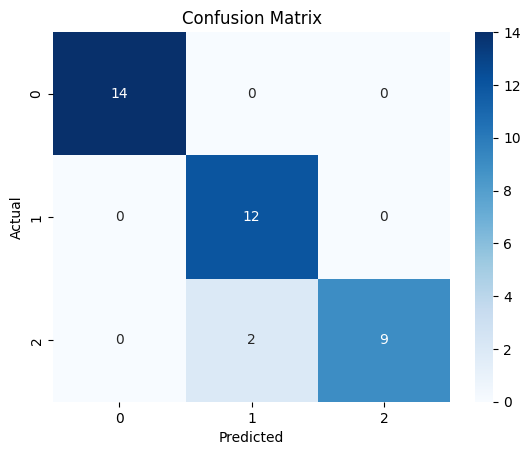

In [25]:
from sklearn.metrics import confusion_matrix # import the function

# rename the DataFrame variable
conf_matrix_df = confusion_matrix(predictions_pd["indexedLabel"], predictions_pd["prediction"])
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

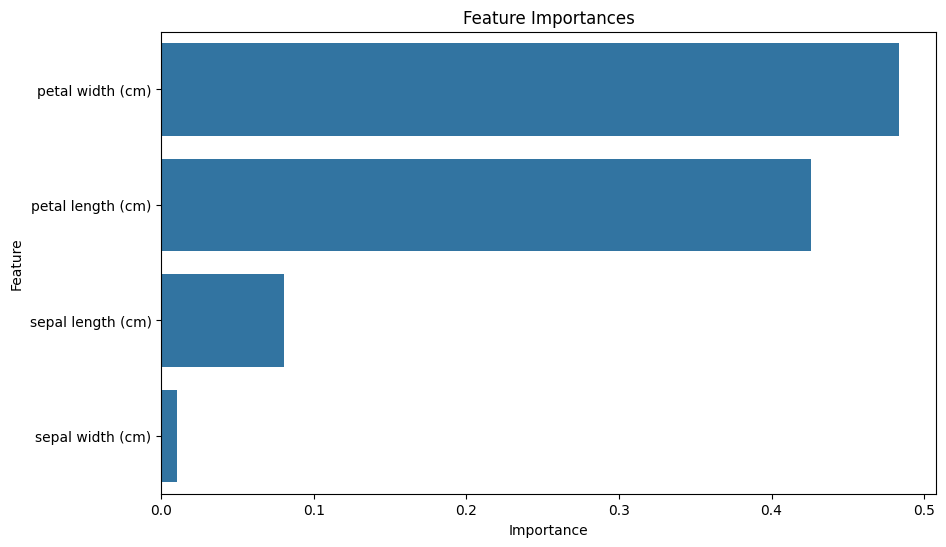

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances_df)
plt.title('Feature Importances')
plt.show()

In [27]:
cv_results = cvModel.avgMetrics
param_maps = cvModel.getEstimatorParamMaps()
param_tuning_df = pd.DataFrame([{**param, "Accuracy": metric} for param, metric in zip(param_maps, cv_results)])
print(param_tuning_df)

   RandomForestClassifier_7887215465ec__numTrees  \
0                                             10   
1                                             10   
2                                             10   
3                                             20   
4                                             20   
5                                             20   
6                                             30   
7                                             30   
8                                             30   

   RandomForestClassifier_7887215465ec__maxDepth  Accuracy  
0                                              5  0.931701  
1                                             10  0.931701  
2                                             15  0.931701  
3                                              5  0.947574  
4                                             10  0.957378  
5                                             15  0.957378  
6                                              5  0.

In [28]:
misclassified = predictions_pd[predictions_pd["indexedLabel"] != predictions_pd["prediction"]]
print("Misclassified examples:")
print(misclassified)

Misclassified examples:
    indexedLabel  prediction
19           2.0         1.0
21           2.0         1.0


In [29]:
data_pd = data.select(data.columns[:-2] + ["indexedLabel"]).toPandas()
data.show()

+-----------------+----------------+-----------------+----------------+-----+-----------------+------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|         features|indexedLabel|
+-----------------+----------------+-----------------+----------------+-----+-----------------+------------+
|              5.1|             3.5|              1.4|             0.2|    0|[5.1,3.5,1.4,0.2]|         0.0|
|              4.9|             3.0|              1.4|             0.2|    0|[4.9,3.0,1.4,0.2]|         0.0|
|              4.7|             3.2|              1.3|             0.2|    0|[4.7,3.2,1.3,0.2]|         0.0|
|              4.6|             3.1|              1.5|             0.2|    0|[4.6,3.1,1.5,0.2]|         0.0|
|              5.0|             3.6|              1.4|             0.2|    0|[5.0,3.6,1.4,0.2]|         0.0|
|              5.4|             3.9|              1.7|             0.4|    0|[5.4,3.9,1.7,0.4]|         0.0|
|              4.6|

In [34]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve


X = data_pd[features_list]
y = data_pd["indexedLabel"]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Unique values in y:", np.unique(y))

train_sizes, train_scores, valid_scores = learning_curve(
    RandomForestClassifier(), X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

print("Train sizes:", train_sizes)
print("Train scores:", train_scores)
print("Validation scores:", valid_scores)

Shape of X: (150, 5)
Shape of y: (150,)
Unique values in y: [0. 1. 2.]
Train sizes: [ 12  24  36  48  60  72  84  96 108 120]
Train scores: [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Validation scores: [[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
 [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
 [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
 [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
 [0.96666667 0.96666667 1.         0.96666667 1.        ]
 [1.         1.         0.96666667 1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
